In [1]:
import pandas as pd
import numpy as np

# from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string, os 
import tensorflow as tf

# keras module for building LSTM 
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Dense, Bidirectional 
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('./Harry Mack Omegle Bars 1 to 50 Lyrics - Sheet1.csv')

In [3]:
df.head()

,Lyrics,Words,Omegle Bars Episode,Fast Flow (Y/N),Flow State (Start/Pocket),Lyric State (Verse/Hook),Link
0,yeah yeah come on aye come on aye come on aye ...,florescent adolescence rainbow wetherspoons,1-1,NaN,Start,NaN,https://www.youtube.com/watch?v=NPdKxsSE5JQ&li...
1,baby peeping my essence,florescent adolescence rainbow wetherspoons,1-1,NaN,In the Pocket,NaN,https://www.youtube.com/watch?v=NPdKxsSE5JQ&li...
2,shining florescent,florescent adolescence rainbow wetherspoons,1-1,NaN,NaN,NaN,https://www.youtube.com/watch?v=NPdKxsSE5JQ&li...
3,I've been doing like that since a young adoles...,florescent adolescence rainbow wetherspoons,1-1,NaN,NaN,NaN,https://www.youtube.com/watch?v=NPdKxsSE5JQ&li...
4,yeah I'm shining,florescent adolescence rainbow wetherspoons,1-1,NaN,NaN,NaN,https://www.youtube.com/watch?v=NPdKxsSE5JQ&li...


In [4]:
df.drop(['Fast Flow (Y/N)', 'Flow State (Start/Pocket)', 'Lyric State (Verse/Hook)', 'Link'], axis=1, inplace=True)

In [5]:
df.head()

,Lyrics,Words,Omegle Bars Episode
0,yeah yeah come on aye come on aye come on aye ...,florescent adolescence rainbow wetherspoons,1-1
1,baby peeping my essence,florescent adolescence rainbow wetherspoons,1-1
2,shining florescent,florescent adolescence rainbow wetherspoons,1-1
3,I've been doing like that since a young adoles...,florescent adolescence rainbow wetherspoons,1-1
4,yeah I'm shining,florescent adolescence rainbow wetherspoons,1-1


In [6]:
df.shape

(120, 3)

In [7]:
df['Number_of_words'] = df['Lyrics'].apply(lambda x: len(str(x).split()))

In [8]:
df['Number_of_words'].describe()

count    120.000000
mean       6.525000
std        3.103163
min        1.000000
25%        4.000000
50%        6.000000
75%        8.000000
max       18.000000
Name: Number_of_words, dtype: float64

<Figure size 864x432 with 0 Axes>

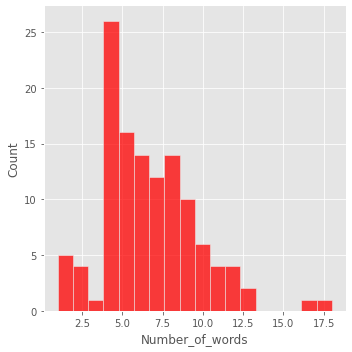

In [9]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.displot(df['Number_of_words'], kde=False, color='red', bins=18)


In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Lyrics'].astype(str).str.lower())

total_words = len(tokenizer.word_index)+1
tokenized_sentences = tokenizer.texts_to_sequences(df['Lyrics'].astype(str))
tokenized_sentences[0]

[6, 6, 23, 18, 27, 23, 18, 27, 23, 18, 27, 23, 18, 27, 23, 18, 27]

In [11]:
input_sequences = list()
for i in tokenized_sentences:
    for t in range(1, len(i)):
        n_gram_sequence = i[:t+1]
        input_sequences.append(n_gram_sequence)
        
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [12]:
input_sequences[:10]

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         6,  6],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,
         6, 23],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  6,
        23, 18],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  6, 23,
        18, 27],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  6, 23, 18,
        27, 23],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  6, 23, 18, 27,
        23, 18],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  6, 23, 18, 27, 23,
        18, 27],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  6, 23, 18, 27, 23, 18,
        27, 23],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  6,  6, 23, 18, 27, 23, 18, 27,
        23, 18],
       [ 0,  0,  0,  0,  0,  0,  0,  6,  6, 23, 18, 27, 23, 18, 27, 23,
        18, 27]])

In [13]:
X, labels = input_sequences[:,:-1], input_sequences[:,-1]
y = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [14]:
model = Sequential()
model.add(Embedding(total_words, 40, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(250)))
model.add(Dropout(0.1))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
earlystop = EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto')
history = model.fit(X, y, epochs=20, verbose=1, callbacks=[earlystop])

Epoch 1/20
21/21 [==============================] - 3s 32ms/step - loss: 5.6243 - accuracy: 0.0422
Epoch 2/20
21/21 [==============================] - 1s 32ms/step - loss: 5.2785 - accuracy: 0.0452
Epoch 3/20
21/21 [==============================] - 1s 32ms/step - loss: 5.1760 - accuracy: 0.0437
Epoch 4/20
21/21 [==============================] - 1s 33ms/step - loss: 5.0880 - accuracy: 0.0483
Epoch 5/20
21/21 [==============================] - 1s 33ms/step - loss: 5.0042 - accuracy: 0.0468
Epoch 6/20
21/21 [==============================] - 1s 33ms/step - loss: 4.8873 - accuracy: 0.0498
Epoch 7/20
21/21 [==============================] - 1s 33ms/step - loss: 4.7959 - accuracy: 0.0618
Epoch 8/20
21/21 [==============================] - 1s 33ms/step - loss: 4.7147 - accuracy: 0.0649
Epoch 9/20
21/21 [==============================] - 1s 33ms/step - loss: 4.6350 - accuracy: 0.0588
Epoch 10/20
21/21 [==============================] - 1s 38ms/step - loss: 4.5447 - accuracy: 0.0694
Epoch 11/

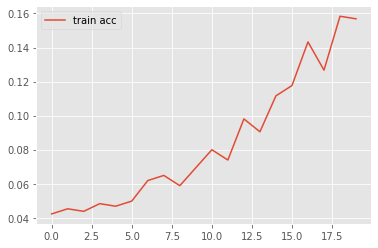

<Figure size 432x288 with 0 Axes>

In [15]:
plt.plot(history.history['accuracy'], label='train acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [16]:
def complete_this_song(seed_text, next_words):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict(token_list, verbose=0).all()
        
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

In [17]:
complete_this_song('water bottle', 50)

"water bottle i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm i'm"